In [108]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sb
from category_encoders import *
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



In [98]:
data = pd.read_csv("parfumo_data.csv")
data = data.drop(['name'], axis=1)
data =data.dropna()


/home/laguna/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [99]:
y = data.filter(["rating"])

## Eval Accords

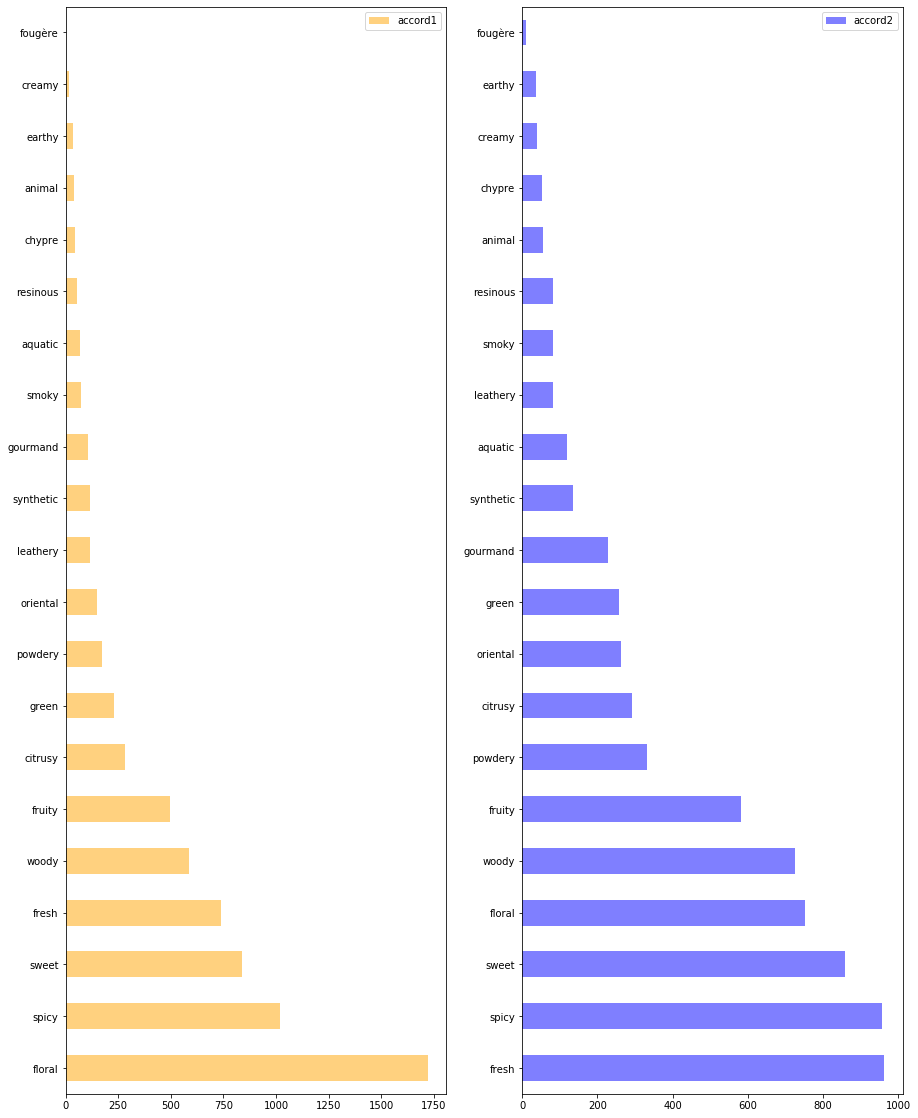

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,20))
data["accord1"].value_counts().plot(kind="barh", alpha=0.5, legend=True, color="orange", ax=axes[0])
data["accord2"].value_counts().plot(kind="barh", alpha=0.5, legend=True, color="blue", ax=axes[1])


## Encode Categories

In [101]:
data['accord1'] = data['accord1'].astype('category')
data['accord2'] = data['accord2'].astype('category')
data['brand'] = data['brand'].astype('category')

cols=["accord1", "accord2", "brand"]

In [102]:
display(data)

,brand,year,rating,votes,longevity,sillage,accord1,accord2
0,4160_Tuesdays,2013.0,76.7568,37.0,79.5000,76.5000,sweet,spicy
1,4160_Tuesdays,2015.0,81.5714,35.0,75.4167,67.8261,gourmand,sweet
2,4160_Tuesdays,2016.0,76.7742,31.0,83.9130,76.5217,fruity,floral
4,4160_Tuesdays,2013.0,72.9630,27.0,70.2174,63.0435,sweet,woody
5,4160_Tuesdays,2017.0,80.0000,20.0,79.4118,67.6471,spicy,woody
...,...,...,...,...,...,...,...,...
8456,Zoologist,2019.0,80.8491,53.0,85.1020,79.7959,aquatic,spicy
8457,Zoologist,2019.0,73.0769,52.0,86.2791,80.9302,green,spicy
8458,Zoologist,2017.0,75.0000,51.0,77.6744,73.0233,green,fruity
8459,Zoologist,2019.0,75.8163,49.0,81.7073,74.3902,floral,sweet


In [115]:
enc = BinaryEncoder(cols=cols).fit(data)
numerical_data = enc.transform(data)

y = numerical_data.filter(["rating"])
X = numerical_data.drop(["rating"],axis=1)

# print(y)
# print(X)


In [104]:
display(numerical_data)



,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,...,accord1_2,accord1_3,accord1_4,accord1_5,accord2_0,accord2_1,accord2_2,accord2_3,accord2_4,accord2_5
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,1,0,1,1,0,1,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,1,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,1,0,1
5,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,0,1,1,0,1,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
8457,0,1,1,0,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
8458,0,1,1,0,1,1,0,1,0,1,...,1,1,0,0,0,0,1,0,1,0
8459,0,1,1,0,1,1,0,1,0,1,...,0,1,1,1,0,1,0,0,1,1


## Split Data

In [133]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=2)


## 1HE - Trial 1 XGBoost

In [127]:
model = xgb.XGBRegressor(max_depth=4,
                        objective="reg:squarederror", 
                        learning_rate=0.05, 
                        subsample=0.9, 
                        colsample_bylevel=0.5,
                        reg_alpha=0.75, 
                        reg_lambda=0.5,
                        n_estimators=1000)  

In [129]:
folds = KFold(n_splits=10, random_state=5)
results = cross_val_score(model, x_train, y_train, cv=folds, scoring="neg_mean_squared_error")


In [130]:
print(results * -1)

[33.5927942  36.15747341 37.49045615 39.87086534 37.87933028 36.42849089
 37.6639877  35.57385289 37.71461311 36.50378073]


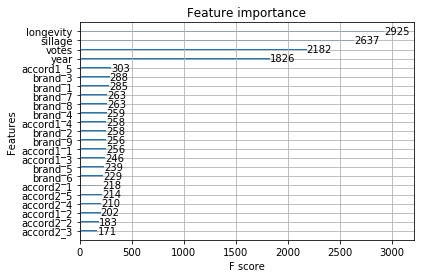

In [137]:
from xgboost import plot_importance
model.fit(x_train, y_train)

plot_importance(model)

## 1HE - Trial 2 Elastic Net

In [131]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha = 0.1, fit_intercept=True)

In [134]:
enet_results = cross_val_score(enet, x_train, y_train, cv=folds, scoring="neg_mean_squared_error")

In [144]:
print(enet_results * -1)

[39.95806724 40.15951524 43.34495209 34.72472919 43.43917636 41.76849206
 37.45325074 40.65591887 39.07232024 38.56265664]


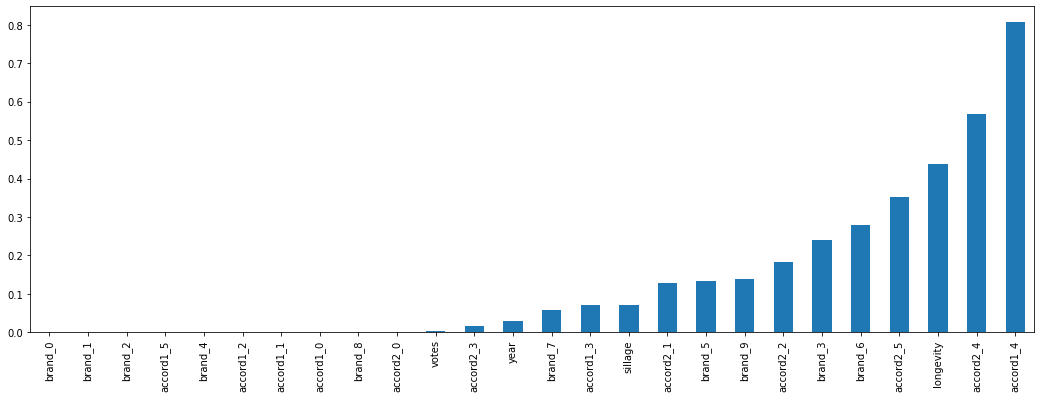

In [143]:
enet.fit(x_train, y_train)

feat_imp = pd.Series(index = x_train.columns, data = np.abs(enet.coef_))
feat_imp.sort_values().plot(kind = 'bar', figsize = (18,6))